# Import packages needed for mappdf demo

In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import pearsonr

from diffpy.pdfgetx import PDFGetter, PDFConfig

# utils for mapPDF
from utils import *

# bSeabornStyle()

# Define filepath to informations

In [2]:
# defined example files
meta_data_fp = 'meta/20161115-220716_grid_scan_md2.txt'
chi_dir = 'chi/'
background_fp = 'background/PCA_background.txt'

# Load raw I(Q) data

In [3]:
pdf_params = dict(qmaxinst=17, qmin=0.8, qmax=17, dataformat='Qnm',
                   rmin=0.0, rmax=100.0, rstep=0.01)
# load real background
pdfgetter = PDFGetter()
bkg_q, bkg_Iq = np.loadtxt(background_fp).T
r, PCA_bkg_Gr = pdfgetter(bkg_q, bkg_Iq, composition='C', **pdf_params)

# load lookup table
# optional; to exclude function
qoi_colmns  = ['diff_x', 'diff_y', 'filename']
df = mappdf_load_chi(meta_data_fp, qoi_columns=qoi_colmns, root=chi_dir)

process_chi_df(df, ['CPtCu']*len(df), pdf_params, 
               background=bkg_Iq, iq_pearson_data=bkg_Iq, gr_pearson_data=PCA_bkg_Gr)




In [4]:
# view the first 5 rows for example
df.head()

,diff_x,diff_y,filename,q,iq,iq_pearson,corrected_iq,gr,gr_pearson
0,9.4,25.44,Catalyst_Array_DenseMap_075785_0001.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.7301698, 5.7302208...",0.994213,"[4.31458187665e-15, -2.71157410979e-15, -1.422...","[0.0, 0.00205521680573, 0.00405164310387, 0.00...",-0.296943
1,9.4,24.44,Catalyst_Array_DenseMap_075785_0002.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.0435905, 4.0436268...",0.999834,"[4.31458187665e-15, -2.71157410979e-15, -1.422...","[0.0, 0.00178451593679, 0.00351791218884, 0.00...",0.180459
2,9.4,23.44,Catalyst_Array_DenseMap_075785_0003.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0133491, 5.0133934...",0.999568,"[4.31458187665e-15, -2.71157410979e-15, -1.422...","[0.0, 0.00694843158312, 0.0136922526729, 0.020...",0.687132
3,9.4,22.44,Catalyst_Array_DenseMap_075785_0004.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 4.7433209, 4.7433634...",0.999714,"[4.31458187665e-15, -2.71157410979e-15, -1.422...","[0.0, -0.00433717410744, -0.00854604258661, -0...",0.769582
4,9.4,21.44,Catalyst_Array_DenseMap_075785_0005.chi,"[0.1204624, 0.36138719, 0.60231203, 0.8432368,...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.9600918, 3.9601269...",0.999381,"[4.31458187665e-15, -2.71157410979e-15, -1.422...","[0.0, 0.00452513161279, 0.0089178556999, 0.013...",0.270279


# Pearson map of I(Q) wrt backgrounds for first screening 

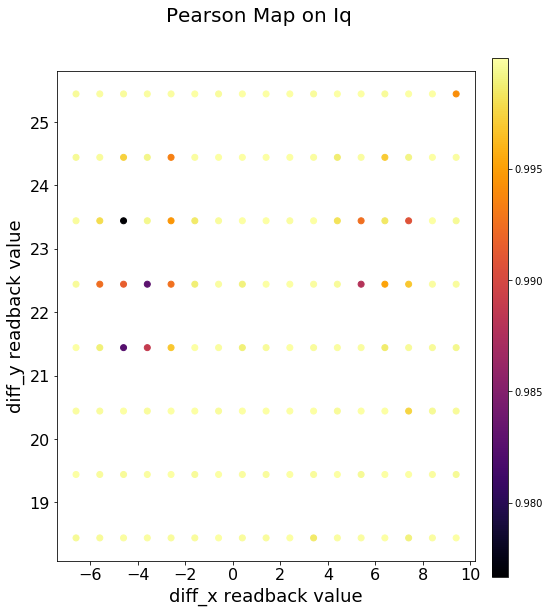

In [5]:
plt.set_cmap('inferno')
# create scatter plot with pearson map
fig, ax = plt.subplots(1,1, figsize=(7.5,9), sharey=True)
fig.suptitle('Pearson Map on Iq', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['iq_pearson'])
fig.colorbar(im, cax=cax)

ax.set_ylabel('diff_y readback value')
ax.set_xlabel('diff_x readback value')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)

# Visualize 95% confidence interval (CI) of transformed Gr_array

Text(0,0.5,'G($\\mathrm{\\AA}^{-2}$)')

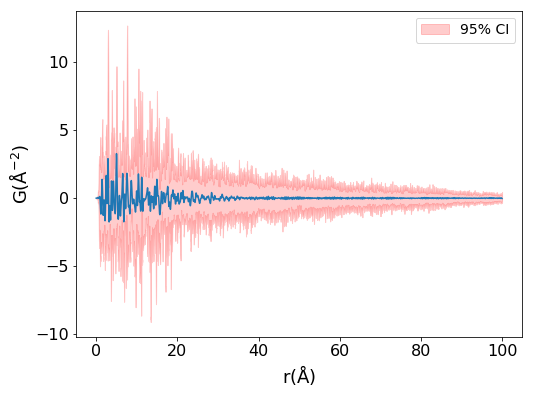

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
low, high = np.percentile(np.asarray(list(df['gr'])), axis=0, q=[2.5, 97.5])
ax.plot(r, df['gr'].mean(0))
ax.fill_between(r, low, high, color='r', alpha=0.2, label='95% CI')
ax.legend(fontsize=14)
conf_label_size(ax, 18)
conf_tick_size(ax, 16)
ax.set_xlabel(r'r($\mathrm{\AA}$)')
ax.set_ylabel(r'G($\mathrm{\AA}^{-2}$)')

# Pearson map of G(r)

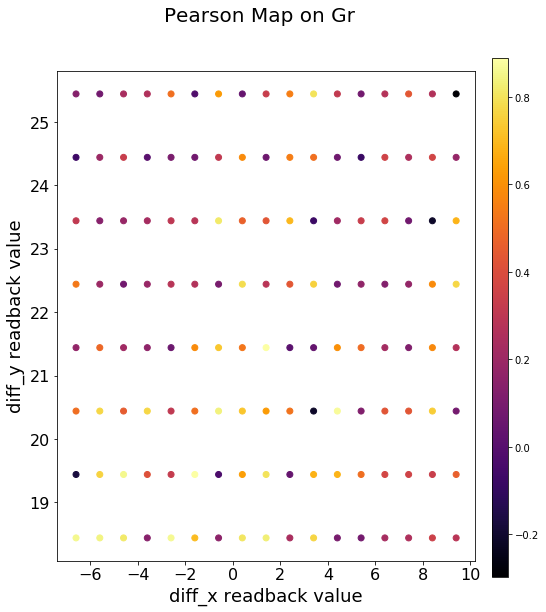

In [7]:
plt.set_cmap('inferno')
# create scatter plot with pearson map
fig, ax = plt.subplots(1,1, figsize=(7.5,9), sharey=True)
fig.suptitle('Pearson Map on Gr', fontsize=20)
cax = fig.add_axes((0.93,0.1,0.03,0.8))
im = ax.scatter(df['diff_x'], df['diff_y'], c=df['gr_pearson'])
fig.colorbar(im, cax=cax)

ax.set_ylabel('diff_y readback value')
ax.set_xlabel('diff_x readback value')
conf_label_size(ax, 18)
conf_tick_size(ax, 16)